In [1]:
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt

import hd_functions as hd

In [2]:
# Set experiment details.
superdir = '/Users/andrewhill/Desktop/tbp'
#superdir = '/Users/andrewhill/Fisher Lab Dropbox/Andrew Hill/2p-data-processed'
expt = '250619-EPG-7f-5HT'
fly = 'fly1'
session = f'{fly}-001'

rawF = np.load(f'{superdir}/{expt}/{fly}/{session}-pv/{session}-F-array.npy')

num_rois = len(rawF[0, :])
num_cycles = len(rawF)

rawF.shape

(1814, 16)

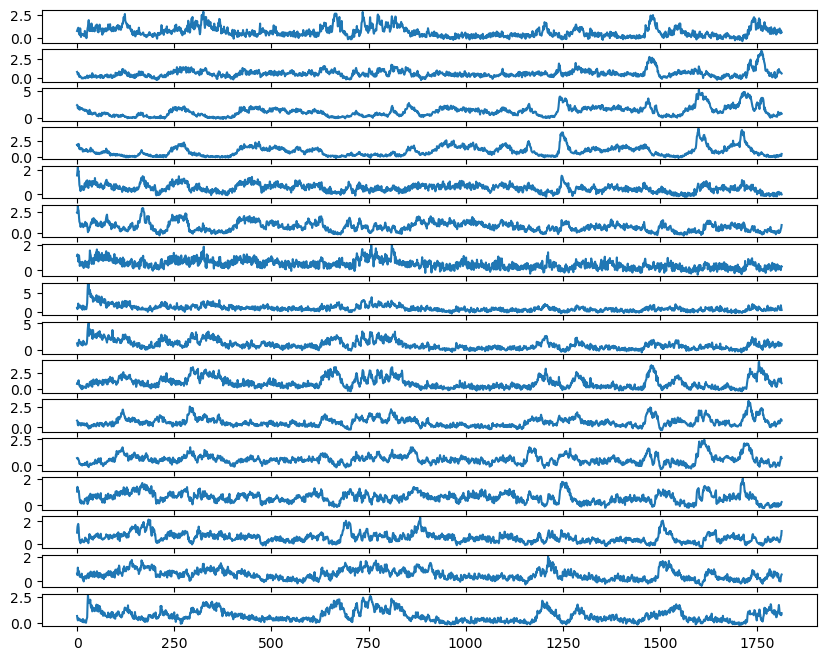

In [3]:
# Convert raw fluorescence to ∆F/Fo with Fo equal to bottom 5th percentile of F values per glom.

Fo_cutoff = 0.05 # Bottom fifth percentile?
Fo = np.quantile(rawF, Fo_cutoff, axis = 0)

dFF = np.zeros([num_cycles, num_rois])
for r in range(num_rois):
    dFF[:, r] = (rawF[:, r] - Fo[r])/(Fo[r])

fig, axs = plt.subplots(num_rois, 1, figsize = (10,8))
for r in range(num_rois):
    ax = axs[r]
    ax.plot(dFF[:, r])
plt.show()

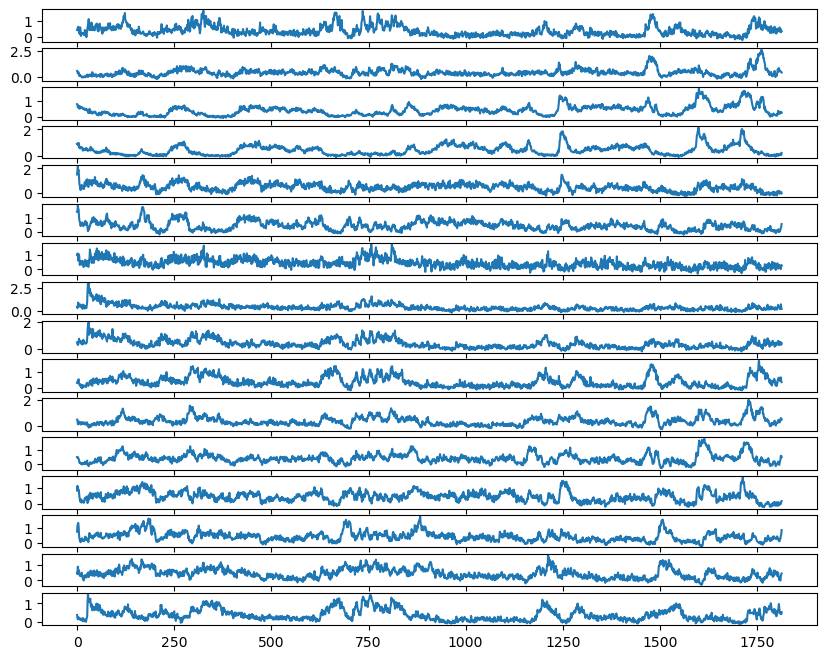

In [4]:
# Normalize ∆F/Fo to top 95th percentile of F values per glom.

normF_cutoff = 0.95
normF_factor = np.quantile(dFF, normF_cutoff, axis = 0)

normF = np.zeros([num_cycles, num_rois])
for r in range(num_rois):
    normF[:, r] = dFF[:, r]/normF_factor[r]

fig, axs = plt.subplots(num_rois, 1, figsize = (10,8))
for r in range(num_rois):
    ax = axs[r]
    ax.plot(normF[:, r])
plt.show()

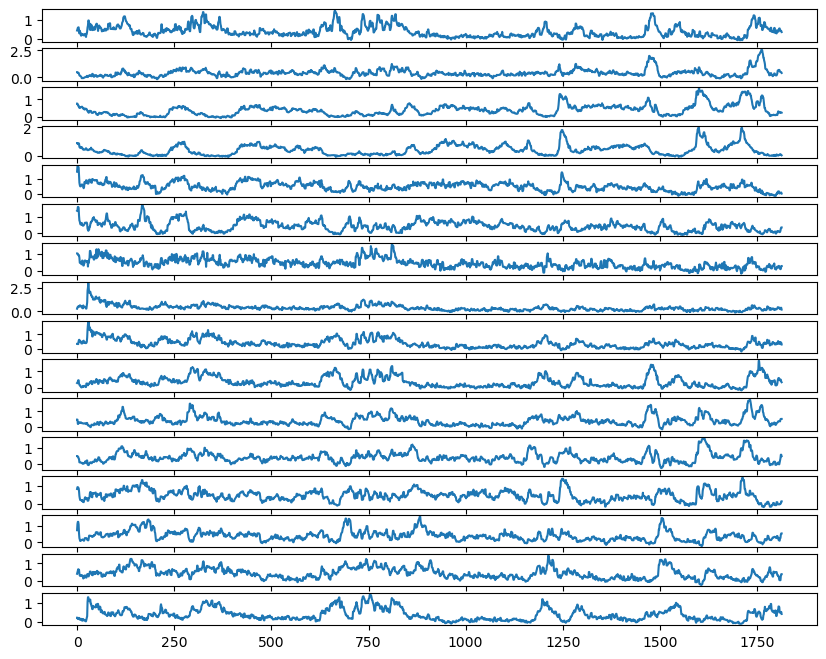

In [5]:
# Median filter the normalized F. 

for r in range(num_rois):
    normF[:, r] = signal.medfilt(normF[:, r], kernel_size = 3)

fig, axs = plt.subplots(num_rois, 1, figsize = (10,8))
for r in range(num_rois):
    ax = axs[r]
    ax.plot(normF[:, r])
plt.show()

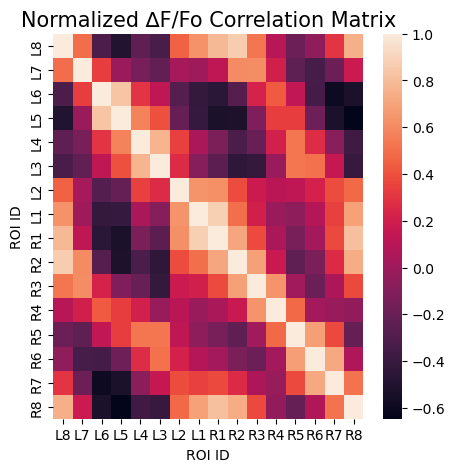

In [6]:
normF_dataframe = pd.DataFrame(normF, columns = ['L8', 'L7', 'L6', 'L5', 'L4', 'L3', 'L2' ,'L1',
                                                 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8'])

normF_corr_matrix = normF_dataframe.corr()

plt.figure(figsize = (5,5))
sns.heatmap(normF_corr_matrix)
plt.xlabel('ROI ID', fontsize = 10)
plt.ylabel('ROI ID', fontsize = 10)
plt.title('Normalized ∆F/Fo Correlation Matrix', fontsize = 15)
plt.show()

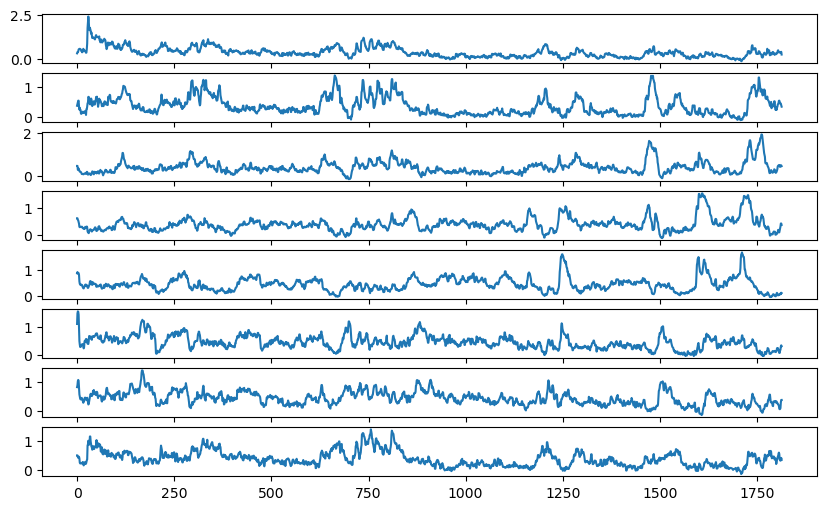

In [7]:
roi_mask = tifffile.imread(f'{superdir}/{expt}/{fly}/{session}-pv/{session}-ROI-mask.tif')
roi_mask = np.squeeze(roi_mask)

num_merged_rois = int(num_rois/2)
normF_merged_bridges = hd.merge_gloms(normF, roi_mask, num_merged_rois)

fig, axs = plt.subplots(num_merged_rois, 1, figsize = (10,6))
for r in range(num_merged_rois):
    ax = axs[r]
    ax.plot(normF_merged_bridges[:, r])
plt.show()

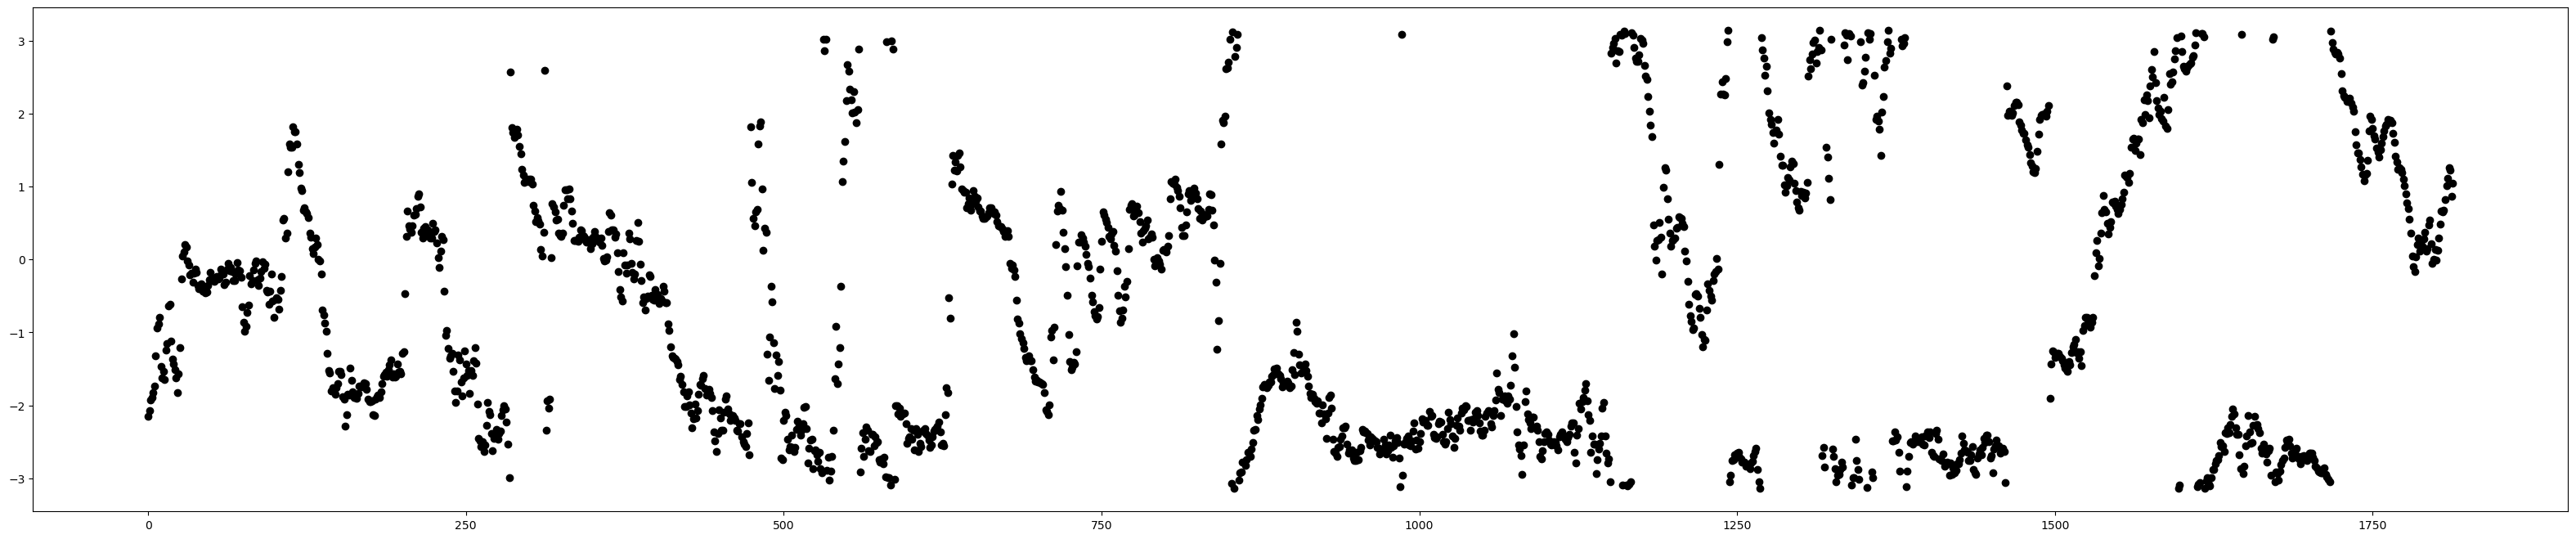

In [8]:
# PVA

PVA_rad, PVA_str = hd.PVA_calc(normF_merged_bridges)

plt.figure(figsize = (40,8))
plt.scatter(np.arange(len(PVA_rad)), PVA_rad, color = 'black')
plt.show()

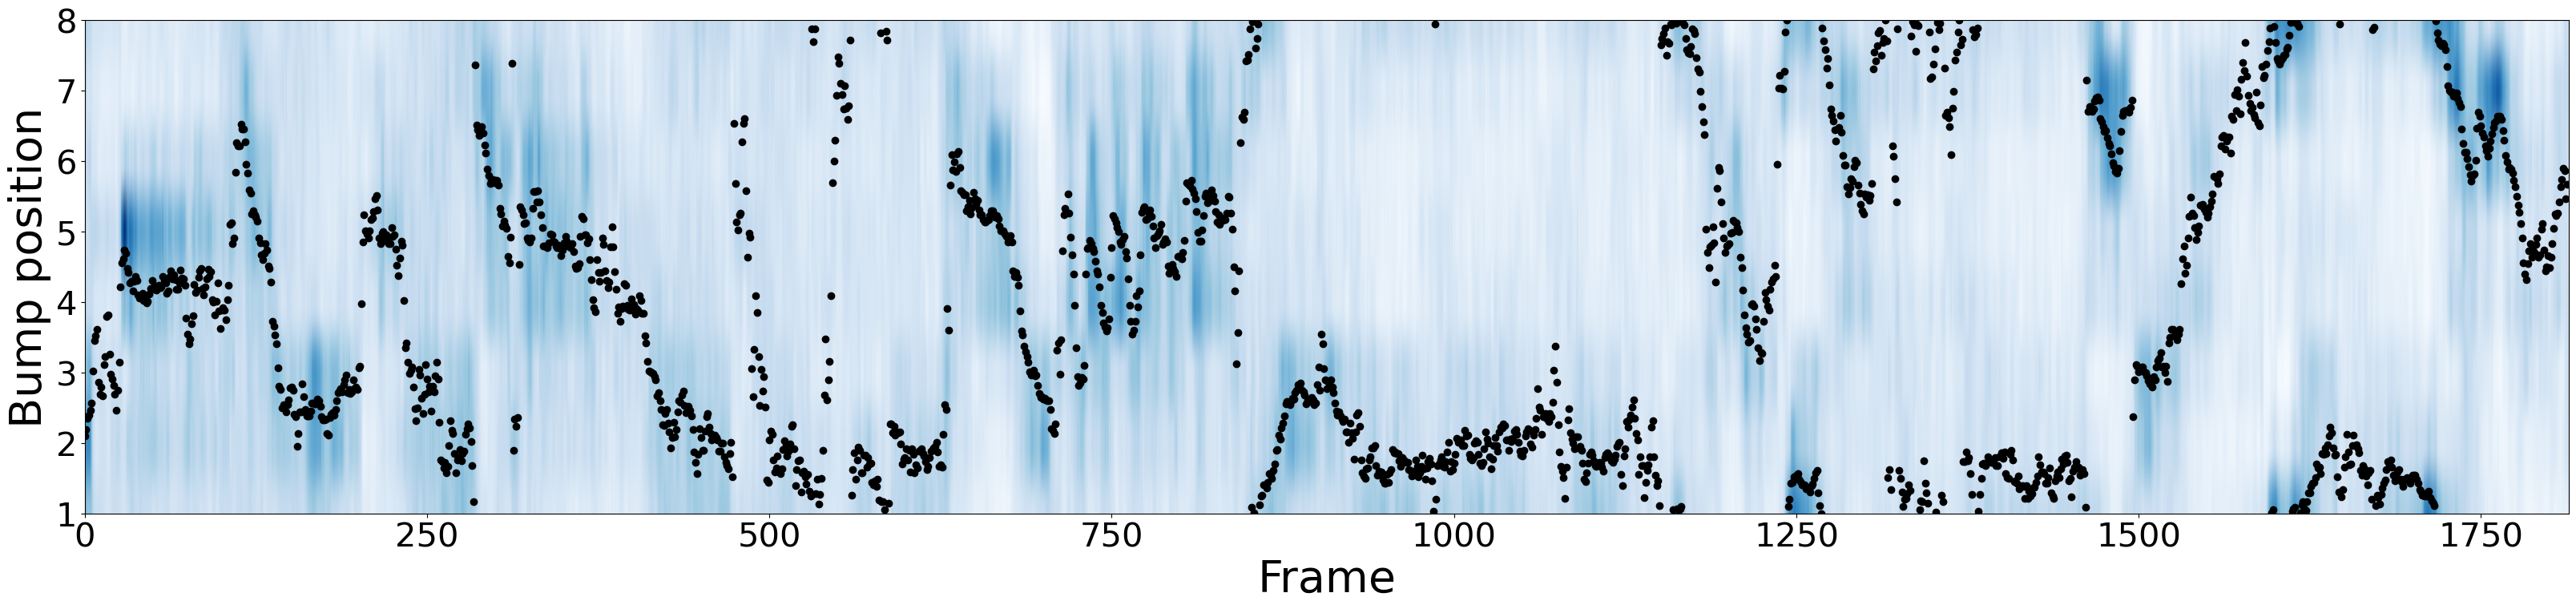

In [9]:
normF_for_plot = normF_merged_bridges.transpose()
normF_for_plot_shifted = np.zeros((np.size(normF_for_plot, 0), np.size(normF_for_plot, 1)))

for r in range(len(normF_for_plot)):
    normF_for_plot_shifted[r, :] = normF_for_plot[(r+4)%8, :]

plt.figure(figsize = (40,8))
plt.imshow(normF_for_plot_shifted, aspect = 'auto', cmap = 'Blues')
plt.xlabel('Frame', fontsize = 40)
plt.ylabel('Bump position', fontsize = 40)
plt.xticks(ticks = plt.xticks()[0][0:], labels = np.array(plt.xticks()[0][0:], dtype = np.int64), fontsize = 30)
plt.yticks(ticks = plt.yticks()[0][0:], labels = np.array(plt.yticks()[0][0:]+1, dtype = np.int64), fontsize = 30)
plt.xlim(0, num_cycles)
plt.ylim(0,7)

plt.scatter(np.arange(len(PVA_rad)), ((PVA_rad+np.pi)/(2*np.pi))*7, color = 'black')

plt.show()